In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from matplotlib import cm
from formulaic import Formula
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from time import time

/opt/miniconda3/envs/alc/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Instalar las siguientes librerias y reiniciar el kernel

In [2]:
!pip install tensorflow
!pip install keras
!pip install ipympl

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.2 MB/s eta 0:00:0000:0100:07
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 922.7 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Para Windows (descomentar y ejecutar):

In [ ]:
#%matplotlib notebook

Para Linux (decomentar y ejecutar):

In [2]:
%matplotlib widget

# Descenso Por Gradiente

### Laboratorio de Datos, IC - FCEN - UBA - 1er. Cuatrimestre 2024

Importamos el Regresor basado en Tensorflow y Keras. Ya viene implementado con Descenso por Gradiente y Descenso por 
Gradiente Estocástico. Sirve para hacer Regresión (Lineal y no Lineal) y para clasificación con Regresión Logística.

También importamos la función ``train_test_split_scale_center`` que separa los datos en entrenamiento y testeo, aplica ``MinMaxScaler`` y, opcionalmente, los
centra.

In [3]:
from tf_regressor import Regressor, train_test_split_scale_center

### Motivación 1

Resolver sistemas de ecuaciones *grandes* es computacionalmente costoso. Veamos un ejemplo, con un dataset sintético 
de $11000$ observaciones de $10000$ features cada una (un total de $110$ millones de valores).

Utilizamos el modelo:
$$Y = \beta_0 + \sum_{i=1}^{10000} \beta_iX_i$$

In [95]:
# Generamos 11000 muestras aleatorias con 10000 features cada una
np.random.seed(11)
n, m = 11000, 10000
mega_X = np.random.randn(n, m)
simulation_weights = np.random.randint(3, size=mega_X.shape[1])
mega_Y = (mega_X @ simulation_weights + np.random.randn(int(n)) / 10).reshape(-1, 1) # reshape para volverlo una columna

# Normalizamos los datos y los centramos
mega_X_train, mega_X_test, mega_y_train, mega_y_test = train_test_split_scale_center(mega_X, mega_Y,
                                                                                     transform_y=True,
                                                                                     test_size=0.2,
                                                                                     random_state=21)

<font color='red'>**CUIDADO AL CORRER ESTO, PUEDE EXPLOTAR**<font>

In [6]:
# Hacemos regresion lineal con scikit-learn
model = linear_model.LinearRegression()
start = time()  # marcamos el tiempo de inicio del entrenamiento
model.fit(mega_X_train, mega_y_train)
tiempo_matricial = time() - start   # registramos el tiempo total de entrenamiento
mse_matricial = mean_squared_error(mega_y_test, model.predict(mega_X_test))
print('Tiempo total de entrenamiento: ', tiempo_matricial)
print('MSE en conjunto de testeo: ', mse_matricial)

Tiempo total de entrenamiento:  315.25099205970764
MSE en conjunto de testeo:  0.002086651203147157


### Motivación 2

Tenemos un dataset con la evolución de nuevos casos diarios de COVID

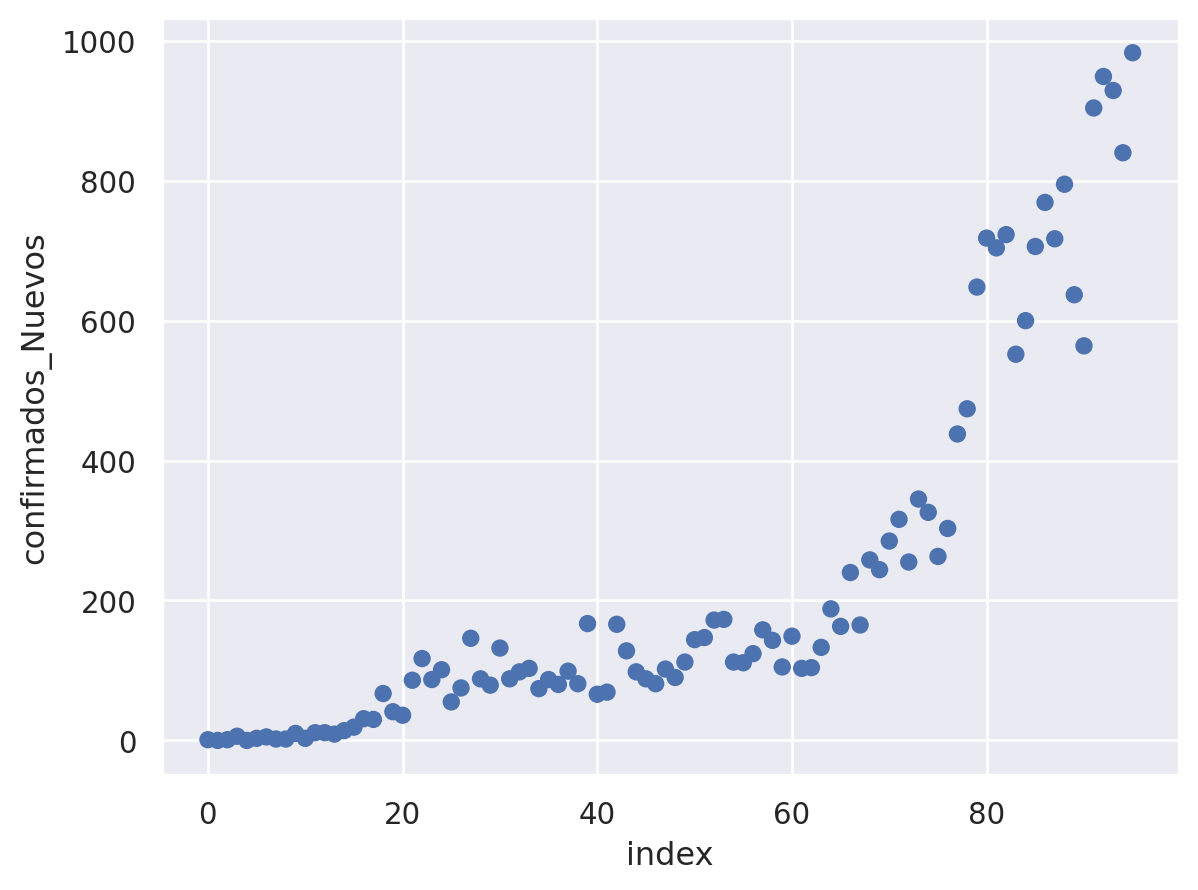

In [8]:
coro = pd.read_csv('casos_coronavirus.csv')
coro.reset_index(inplace=True)      # Reseteamos el índice para trabajar con los indices en vez de las fechas
so.Plot(data=coro, x='index', y='confirmados_Nuevos').add(so.Dot())

¿Qué tipo de función parece que sigue la evolución de los casos? ¿Podemos plantear un modelo de regresión **lineal**?

### 1. Ejemplo: Regresión Lineal con una variable predictora 

Usemos el dataset de ``inmuebles.csv`` para hacer regresión lineal del precio a partir de la superficie del inmueble:
$$precio = b + w\cdot superficie \qquad (precio \sim superficie) $$

In [4]:
# Cargamos el dataset
data = pd.read_csv('inmuebles.csv')

# Normalizamos los datos
X = data['superficie']
y = data['precio']
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y, 
                                                                 transform_y=True,  # Normalizamos y también 
                                                                 center=False,      # No centramos los datos
                                                                 test_size=0.2,     # 20% de los datos para testeo
                                                                 random_state=11)   # Semilla para datos de testeo

In [5]:
# Definimos la funcion del modelo (x, w, b deben respetar ese orden en la declaracion de lambda)
f = lambda x, w, b: b + w*x

In [6]:
# Inicializamos el modelo (por ahora no tiene nada)
model = Regressor()

# Le agregamos la funcion y especificamos la dimension de w 
model.add_f(f,                  # funcion del modelo 
            dim_w=1,            # dimension de w
            random_state=21,    # semilla para selecciones aleatorias
            opt='gd'            # Especificamos que usamos descenso por gradiente
            )

# Entrenamos el modelo con los conjuntos de entrenamiento
model.fit_(X_train, y_train,        # Conjuntos de entrenamiento 
           epochs=200,              # Cantidad de epocas
           validation_split=0.2,    # 20% de datos para validacion
           learning_rate=0.5)      # Learning rate inicial      


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.1794 - val_loss: 0.0840
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0736 - val_loss: 0.0630
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0634 - val_loss: 0.0599
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0580 - val_loss: 0.0548
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0532 - val_loss: 0.0506
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0489 - val_loss: 0.0468
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0450 - val_loss: 0.0433
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0415 - val_loss: 0.0401
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0383 - val_loss: 0.0372
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0353 - val_loss: 0.0346
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0327 - val_loss: 0.0322
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0303 - val_l

In [7]:
# Imprimimos los pesos y el bias resultantes del entrenamiento
print(model.weights_)
print(model.bias_)

[0.9054634]
-0.052973203


In [8]:
# Evaluamos el MSE en el conjunto de testeo
model.evaluate(X_test.to_numpy(), y_test.to_numpy(),        # A TensorFlow no le gustan los DataFrame de pandas 
               return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
               verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
               batch_size=len(y_test))

{'loss': 0.007348397746682167}

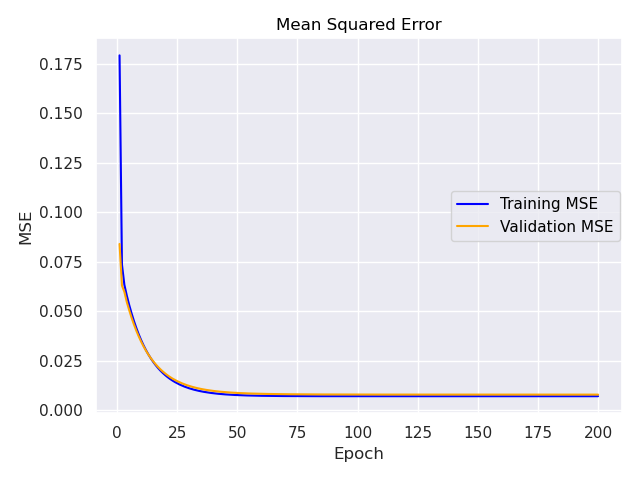

In [9]:
# Podemos graficar la evolución de la función de pérdida (MSE)
model.plot_loss()

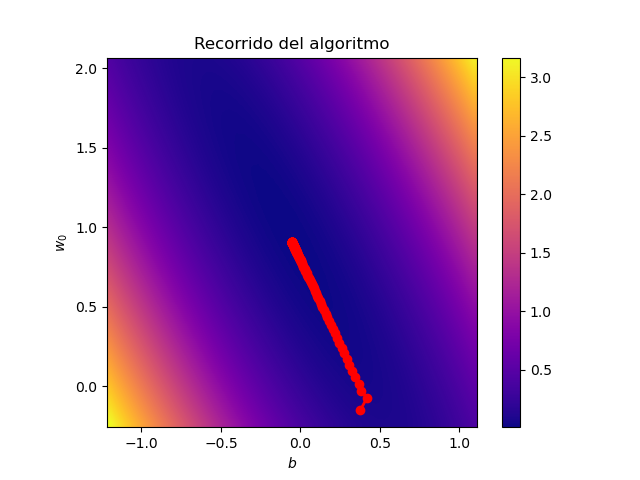

In [10]:
# Podemos graficar como evolucionó el algoritmo a través de las épocas
model.plot_path()

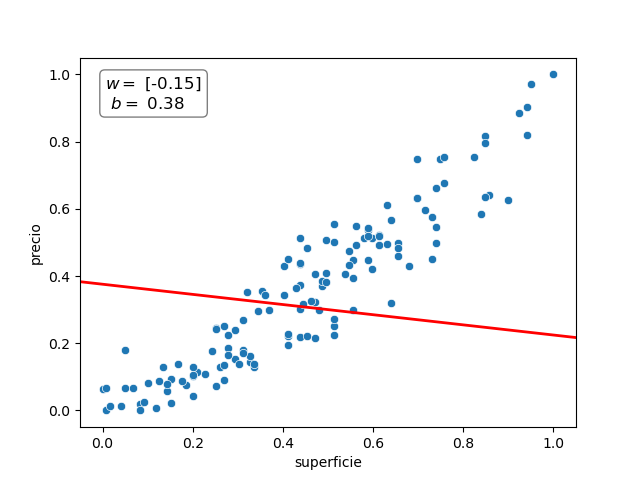

In [11]:
# Y ver una animación de cómo fue evolucionando la regresión
model.animate_regression(X_train, y_train)

**Obs:** el desempeño y el resultado del algoritmo dependen de la elección de pesos y bias inciales

In [12]:
model2 = Regressor()

# Volvamos a entrenar el modelo proporcionándole pesos y bias iniciales
model2.add_f(f,                 # funcion del modelo 
            w0=1,               # peso inicial
            b0=0,               # bias inicial
            opt='gd',            # Especificamos que usamos descenso por gradiente
            random_state=21,    # semilla para selecciones aleatorias
            )

# Entrenamos el modelo con los conjuntos de entrenamiento
model2.fit_(X_train, y_train,        # Conjuntos de entrenamiento 
           epochs=200,              # Cantidad de epocas
           validation_split=0.2,    # 20% de datos para validacion
           learning_rate=0.5)      # Learning rate inicial   

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0166 - val_loss: 0.0087
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0076 - val_loss: 0.0089
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0072 - val_loss: 0.0088
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0072 - val_loss: 0.0088
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0072 - val_loss: 0.0087
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0072 - val_loss: 0.0087
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0072 - val_loss: 0.0087
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0071 - val_loss: 0.0087
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0071 - val_loss: 0.0086
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0071 - val_loss: 0.0086
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0071 - val_loss: 0.0086
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0071 - val_l

In [13]:
# Evaluamos el MSE en el conjunto de testeo
model2.evaluate(X_test.to_numpy(), y_test.to_numpy(),        # A TensorFlow no le gustan los DataFrame de pandas 
               return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
               verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
               batch_size=len(y_test))

{'loss': 0.0073477765545248985}

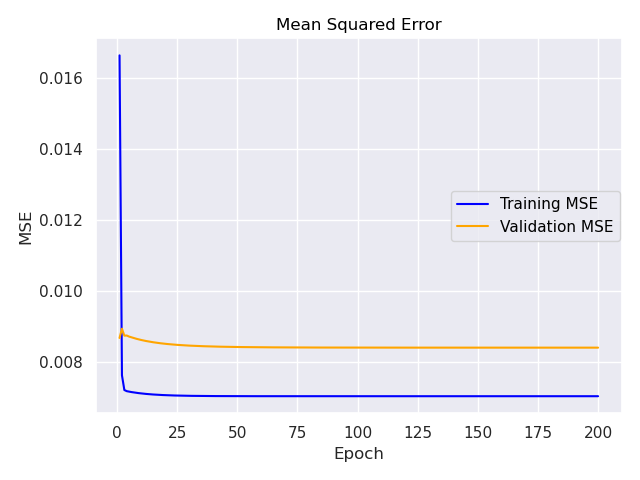

In [14]:
model2.plot_loss()

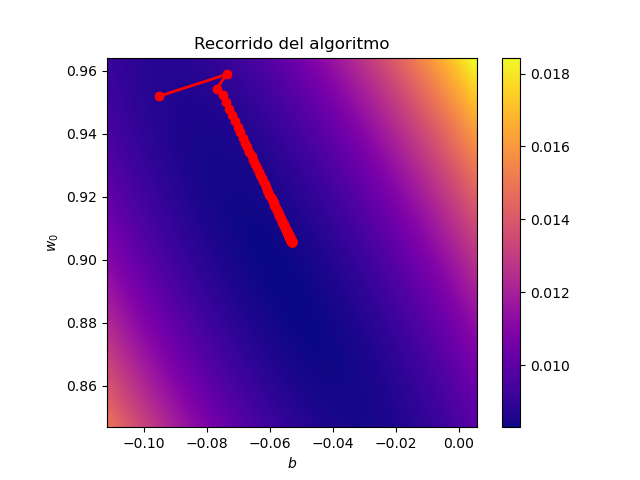

In [15]:
model2.plot_path()

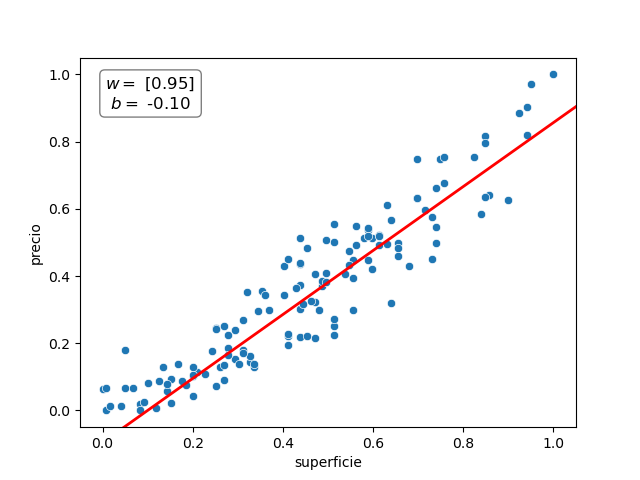

In [16]:
model2.animate_regression(X_train, y_train)

### 2. Ejemplo: Regresión Lineal con más de una variable predictora

Vamos a tratar de predecir el peso de los pingüinos según la longitud de su pico y la de su aleta, y su interacción:
$$body\_mass\_g = b + w_0\cdot bill\_length\_mm + w_1\cdot flipper\_length\_mm + 
w_2\cdot bill\_length\_mm\cdot flipper\_length\_mm$$
o, escrito con la notación de Wilkinson-Rogers: 
$$body\_mass\_g \sim bill\_length\_mm*flipper\_length\_mm$$

In [17]:
# Cargamos el dataset
penguins = sns.load_dataset('penguins')
penguins.dropna(inplace=True)

# Elegimos los features, separamos en entrenamiento y testeo y normalizamos
X = penguins[['bill_length_mm', 'flipper_length_mm']]
y = penguins['body_mass_g']
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y, 
                                                                 transform_y=True,  # Normalizamos y también 
                                                                 center=False,      # No centramos los datos
                                                                 test_size=0.2,     # 20% de los datos para testeo
                                                                 random_state=11)   # Semilla para datos de testeo

# Definimos la funcion del modelo
f = lambda x, w, b: b + w[0]*x[:,0] + w[1]*x[:,1] + w[2]*x[:,0]*x[:,1] 

model3 = Regressor()

# Volvamos a entrenar el modelo con pesos y bias iniciales aleatorios
model3.add_f(f,                 # funcion del modelo
            dim_w= 3,           # dimension de w
            random_state=2077,  # semilla para selecciones aleatorias
            opt='gd'            # Especificamos que usamos descenso por gradiente
            )

# Entrenamos el modelo con los conjuntos de entrenamiento
model3.fit_(X_train, y_train,       # Conjuntos de entrenamiento 
           epochs=200,              # Cantidad de epocas
           validation_split=0.2,    # 20% de datos para validacion
           learning_rate=0.05)      # Learning rate inicial   

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.2537 - val_loss: 0.2319
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2498 - val_loss: 0.2285
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2460 - val_loss: 0.2252
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2422 - val_loss: 0.2219
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2385 - val_loss: 0.2186
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2349 - val_loss: 0.2154
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2314 - val_loss: 0.2123
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2279 - val_loss: 0.2092
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2244 - val_loss: 0.2061
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2210 - val_loss: 0.2031
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2177 - val_loss: 0.2001
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2144 - val_l

In [18]:
# Imprimimos pesos y bias obtenidos con el entrenamiento
print(model3.weights_)
print(model3.bias_)

[-0.14667651  0.6759332  -0.15730257]
0.1710114


In [19]:
# Calculamos el MSE en el conjunto de testeo
model3.evaluate(X_test.to_numpy(), y_test.to_numpy(),        # A TensorFlow no le gustan los DataFrame de pandas 
               return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
               verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
               batch_size=len(y_test))

{'loss': 0.027000466361641884}

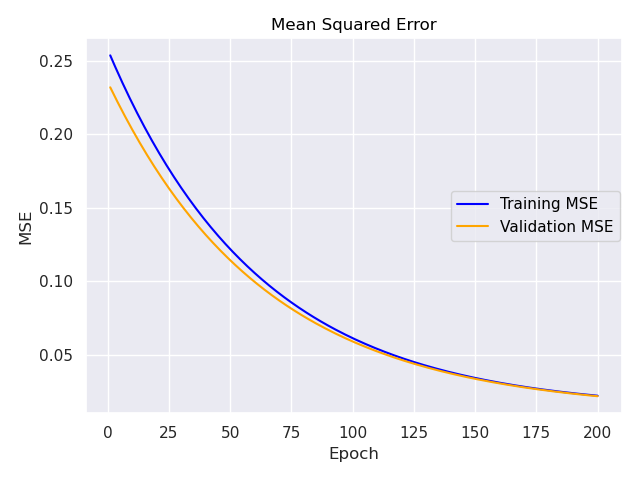

In [20]:
# Graficamos la evolución del MSE
model3.plot_loss()

### 3. Ejemplo: Regresión no lineal

Vamos a realizar Regresión Logística para clasificar pingüinos según su especie (Gentoo o Chinstrap) a partir de su 
peso. 

In [75]:
# Nos quedamos solo con los pingüinos Gentoo o Chinstrap
penguins_clasif = penguins[penguins['species'].isin(['Chinstrap', 'Gentoo'])]

X = penguins_clasif['body_mass_g']
y = penguins_clasif['species']

# Transformamos y a un vector de 1's y 0's:
y = y.apply(lambda t: 1*(t == 'Gentoo'))

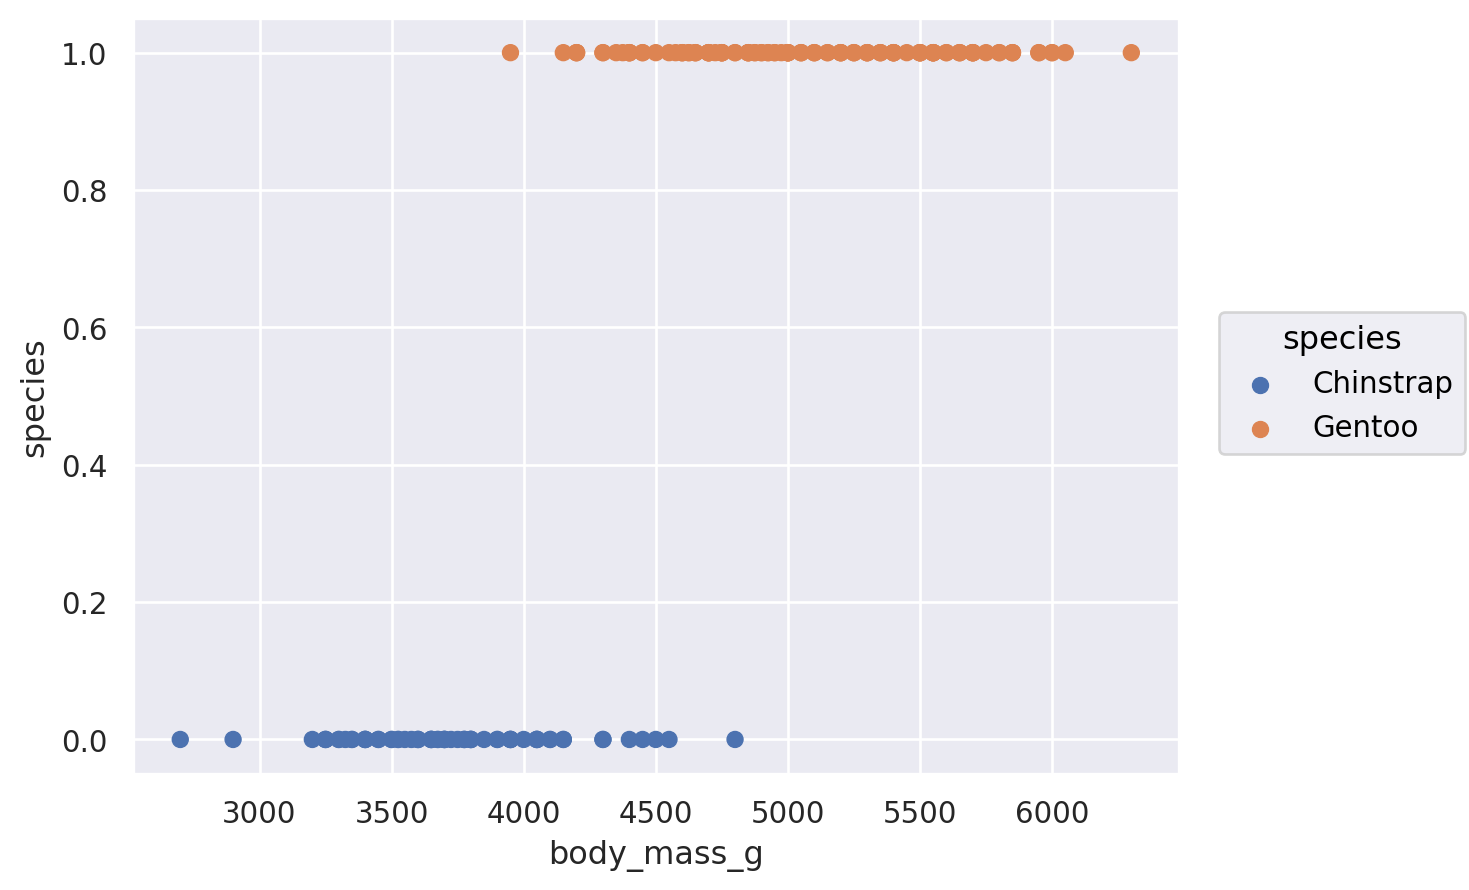

In [76]:
# Graficamos los pesos según la especie
(
    so.Plot()
    .add(so.Dot(), x=X, y=y.iloc[::-1], color=penguins_clasif['species'])
)

In [77]:
# separamos en entrenamiento y testeo, normalizamos y centramos
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y, 
                                                                 test_size=0.2,     # 20% de los datos para testeo
                                                                 random_state=10)   # Semilla para datos de testeo

# Definimos la funcion del modelo
f = lambda x, w, b: 1 / (1 + np.e**(-(b + w*x)))

model4 = Regressor()

# Entrenamos el modelo proporcionándole pesos y bias iniciales
model4.add_f(f,                  # funcion del modelo
            w0 = 0,              # peso incial
            b0 = 0,              # bias inicial
            random_state=21,     # semilla para selecciones aleatorias
            opt='gd'             # Especificamos que usamos descenso por gradiente
            )

# Entrenamos el modelo con los conjuntos de entrenamiento
model4.fit_(X_train, y_train,       # Conjuntos de entrenamiento
            classify=True,          # Indicamos que vamos a clasificar
           epochs=50,              # Cantidad de epocas
           validation_split=0.2,    # 20% de datos para validacion
           learning_rate=0.5)       # Learning rate inicial  

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - binary_accuracy: 0.3691 - binary_crossentropy: 0.6931 - loss: 0.6931 - val_binary_accuracy: 0.4828 - val_binary_crossentropy: 0.6902 - val_loss: 0.6902
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.6309 - binary_crossentropy: 0.6811 - loss: 0.6811 - val_binary_accuracy: 0.4828 - val_binary_crossentropy: 0.6880 - val_loss: 0.6880
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.6309 - binary_crossentropy: 0.6709 - loss: 0.6709 - val_binary_accuracy: 0.4828 - val_binary_crossentropy: 0.6860 - val_loss: 0.6860
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.6309 - binary_crossentropy: 0.6622 - loss: 0.6622 - val_binary_accuracy: 0.4828 - val_binary_crossentropy: 0.6843 - val_loss: 0.6843
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.6309 - binary_crossentropy: 0.6547 - loss: 0.6547 - val_binary_accuracy: 0.4828 - val_binary_crossentropy: 0.6826 - v

In [78]:
# Imprimimos pesos y bias obtenidos con el entrenamiento
print(model4.weights_)
print(model4.bias_)

[1.9575684]
0.55295545


In [79]:
# Calculamos el BCE en el conjunto de testeo
model4.evaluate(X_test.to_numpy(), y_test.to_numpy(),       # A TensorFlow no le gustan los DataFrame de pandas 
               return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
               verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
               batch_size=len(y_test))

{'binary_accuracy': 0.7105262875556946,
 'binary_crossentropy': 0.5127682685852051,
 'loss': 0.5127682685852051}

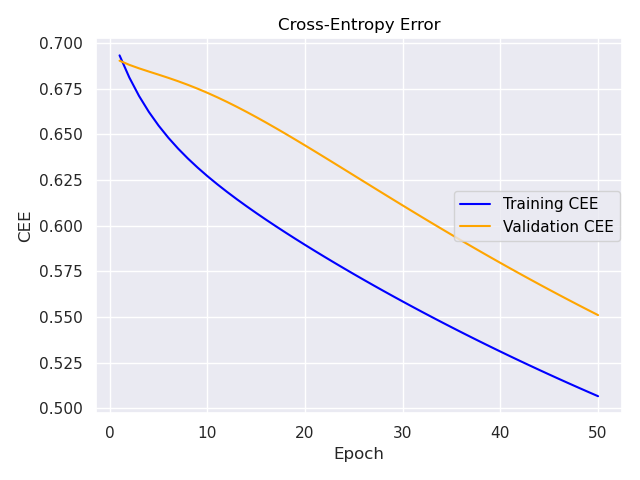

In [80]:
# Graficamos la evolución del BCE
model4.plot_loss()

In [81]:
# Calculamos la prediccion del modelo para X_test
y_pred = (model4.predict(X_test, verbose=0, batch_size=len(y_test)).flatten() > 0.5).astype('int')
y_pred

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

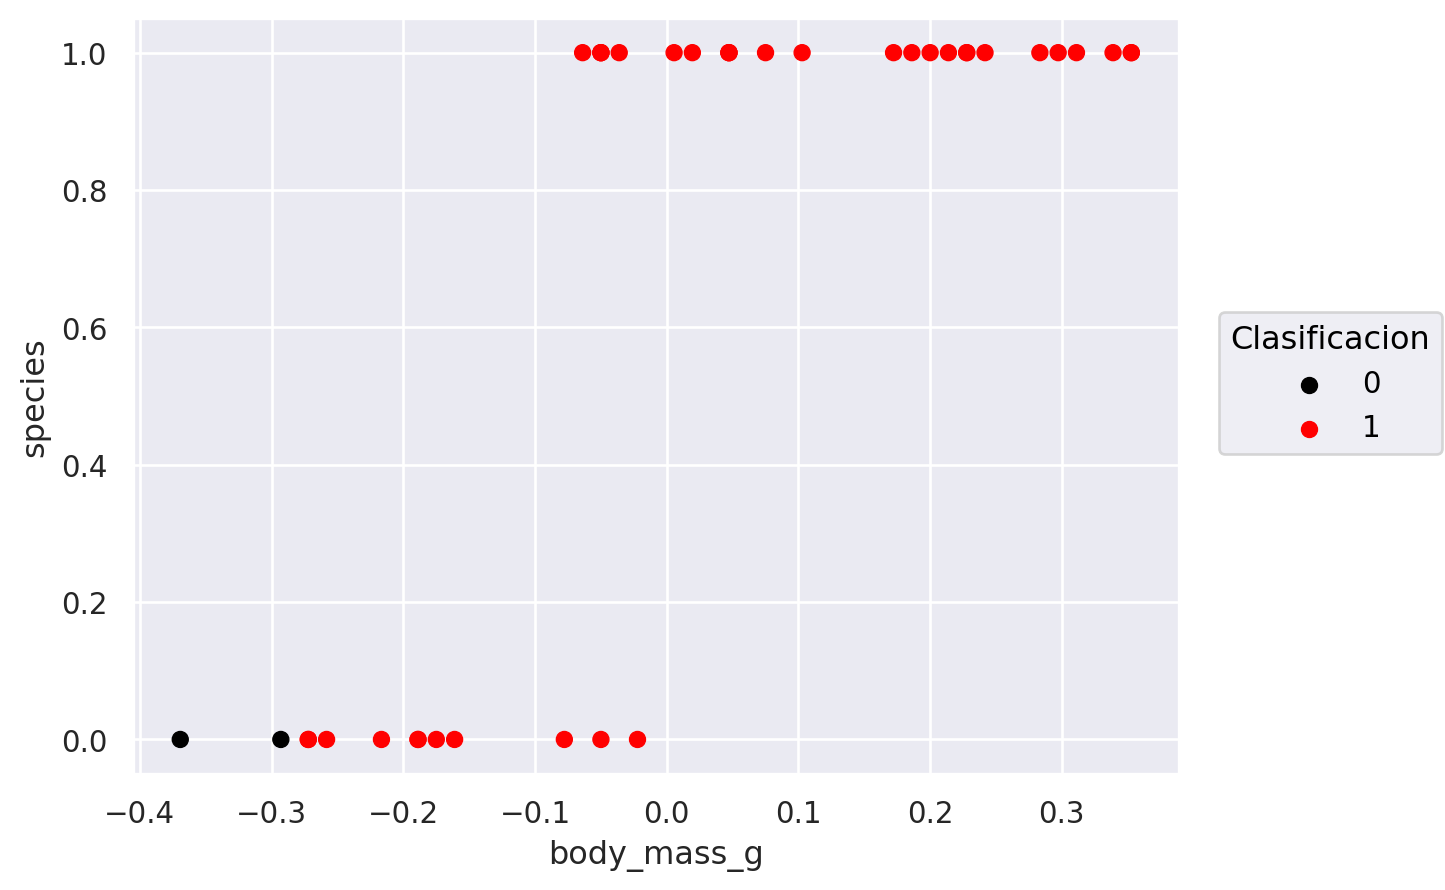

In [82]:
# Graficamos la clasificación
(
    so.Plot(x=X_test, y=y_test, color=y_pred)
    .add(so.Dot())
    .label(color='Clasificacion')
    .scale(color={1: 'red', 0:'black'})
)

/home/Estudiante/labodatos/tf_regressor.py:309: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


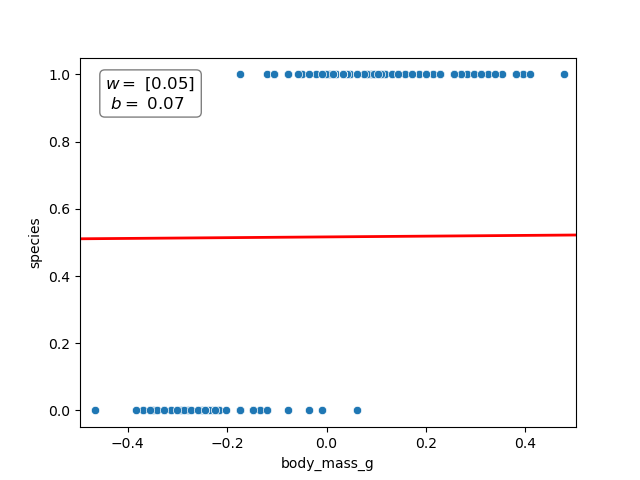

In [83]:
# Animamos la regresion resultante en cada época
model4.animate_regression(X_train, y_train)

### 4. Ejemplo: Descenso por Gradiente Estocástico 

Rehacemos la clasificación anterior, pero usando SGD

In [84]:
# Definimos la funcion del modelo
f = lambda x, w, b: 1 / (1 + np.e**(-(b + w*x)))

model5 = Regressor()

# Volvamos a entrenar el modelo, pero con SGD
model5.add_f(f,                  # funcion del modelo
            w0 = 0,              # peso incial
            b0 = 0,              # bias inicial
            random_state=21,     # semilla para selecciones aleatorias
            )

# Entrenamos el modelo con los conjuntos de entrenamiento
model5.fit_(X_train, y_train,       # Conjuntos de entrenamiento
            classify=True,          # Indicamos que vamos a clasificar
            epochs=50,             # Cantidad de epocas
            batch_size=1,           # tamaño del batch
            validation_split=0.2,   # 20% de datos para validacion
            learning_rate=0.5)      # Learning rate inicial 

Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.7308 - binary_crossentropy: 0.5865 - loss: 0.5865 - val_binary_accuracy: 0.6552 - val_binary_crossentropy: 0.4853 - val_loss: 0.4853
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - binary_accuracy: 0.8832 - binary_crossentropy: 0.3521 - loss: 0.3521 - val_binary_accuracy: 0.9310 - val_binary_crossentropy: 0.3443 - val_loss: 0.3443
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - binary_accuracy: 0.9266 - binary_crossentropy: 0.2842 - loss: 0.2842 - val_binary_accuracy: 0.9310 - val_binary_crossentropy: 0.2830 - val_loss: 0.2830
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - binary_accuracy: 0.9257 - binary_crossentropy: 0.2517 - loss: 0.2517 - val_binary_accuracy: 0.9310 - val_binary_crossentropy: 0.2483 - val_loss: 0.2483
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - binary_accuracy: 0.9257 - binary_crossentropy: 0.2326 - loss: 0.2326 - val_binary_accuracy: 0.9310 - val_binary_cr

In [85]:
# Calculamos el BCE en el conjunto de testeo
model5.evaluate(X_test.to_numpy(), y_test.to_numpy(),       # A TensorFlow no le gustan los DataFrame de pandas 
               return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
               verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
               batch_size=len(y_test))

{'binary_accuracy': 0.9210526347160339,
 'binary_crossentropy': 0.1968240737915039,
 'loss': 0.1968240737915039}

In [86]:
# Comparado con el modelo de Descenso por Gradiente
model4.evaluate(X_test.to_numpy(), y_test.to_numpy(),       # A TensorFlow no le gustan los DataFrame de pandas 
               return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
               verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
               batch_size=len(y_test))

{'binary_accuracy': 0.7105262875556946,
 'binary_crossentropy': 0.5127682685852051,
 'loss': 0.5127682685852051}

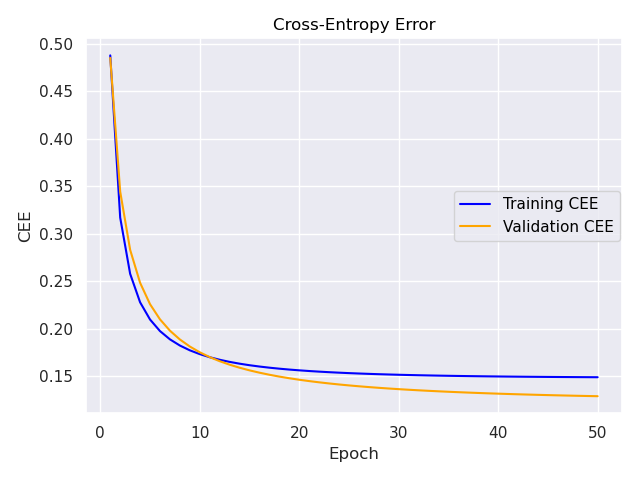

In [87]:
# Graficamos la evolución del BCE
model5.plot_loss()

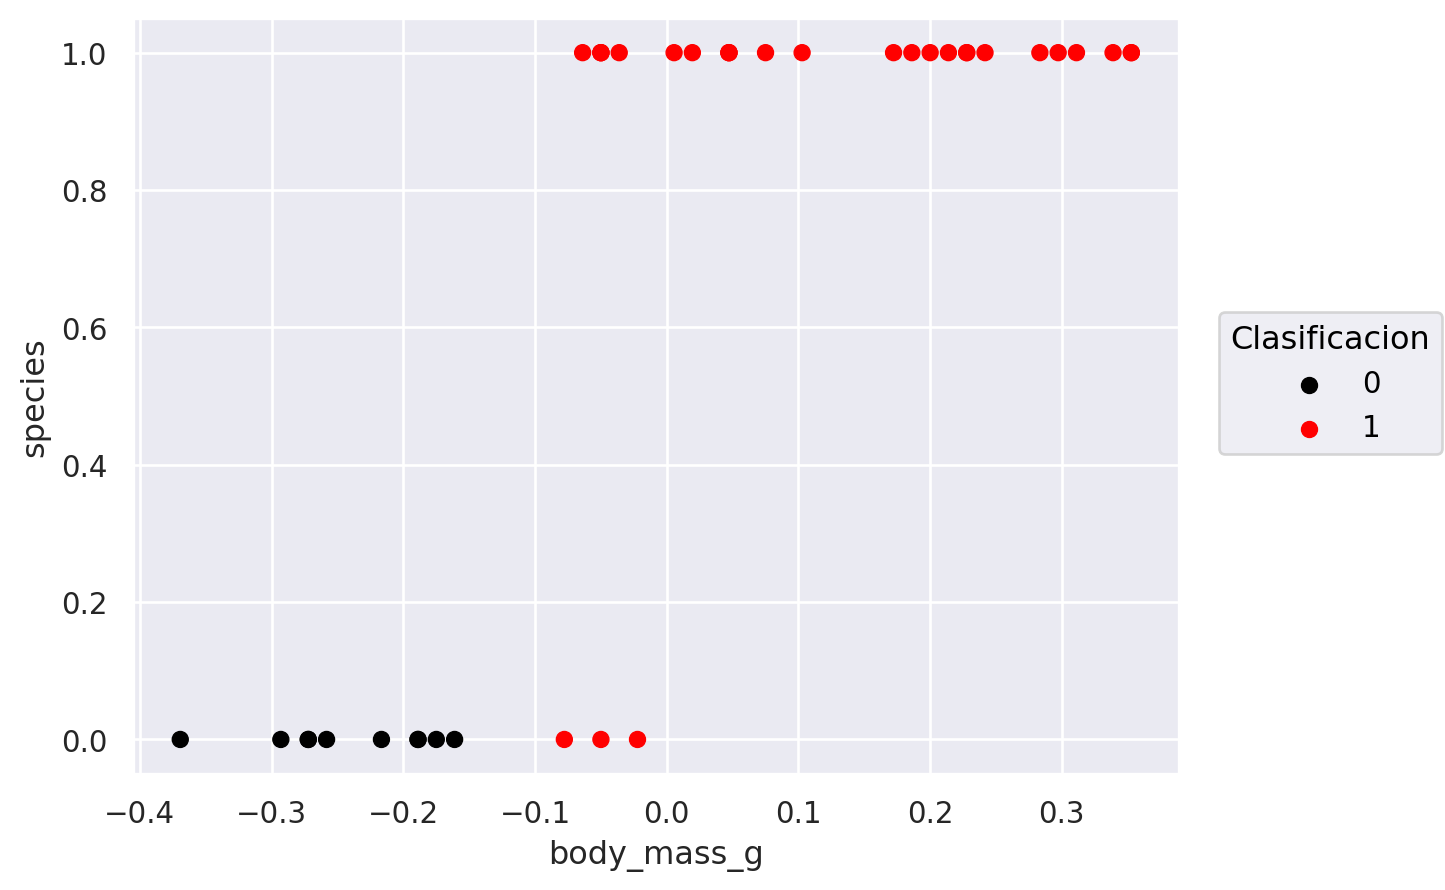

In [88]:
# Calculamos la prediccion del modelo para X_test y graficamos la clasificacion
y_pred = (model5.predict(X_test, verbose=0, batch_size=len(y_test)).flatten() > 0.5).astype('int')
(
    so.Plot(x=X_test, y=y_test, color=y_pred)
    .add(so.Dot())
    .label(color='Clasificacion')
    .scale(color={1: 'red', 0:'black'})
)

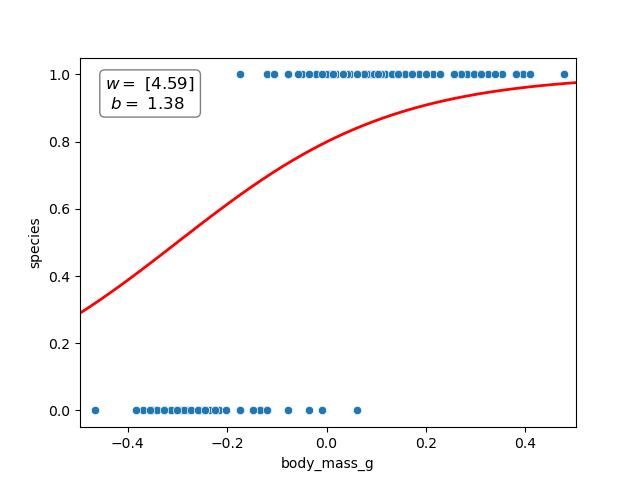

In [ ]:
# Animamos la regresion resultante en cada época
model5.animate_regression(X_train, y_train)

### 5. Extras

#### 5.1 Learning Rate Schedule

In [90]:
# Volvemos a trabajar con el dataset de pinguinos
penguins = sns.load_dataset('penguins')
penguins.dropna(inplace=True)

# Elegimos los features, separamos en entrenamiento y testeo y normalizamos
X = penguins[['bill_length_mm', 'flipper_length_mm']]
y = penguins['body_mass_g']
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y, 
                                                                 transform_y=True,  # Normalizamos y también 
                                                                 center=False,      # No centramos los datos
                                                                 test_size=0.2,     # 20% de los datos para testeo
                                                                 random_state=10)   # Semilla para datos de testeo

# Definimos la funcion del modelo
f = lambda x, w, b: b + w[0]*x[:,0] + w[1]*x[:,1] + w[2]*x[:,0]*x[:,1] 

In [91]:
# Consideramos el modelo con learning rate constante 0.05
model_no_schedule = Regressor()

# Inicializamos el modelo con pesos y bias iniciales aleatorios
model_no_schedule.add_f(f,                  # funcion del modelo
            dim_w= 3,           # dimension de w
            random_state=2077,  # semilla para selecciones aleatorias
            )

# Entrenamos el modelo con los conjuntos de entrenamiento
model_no_schedule.fit_(X_train, y_train,        # Conjuntos de entrenamiento 
           epochs=200,              # Cantidad de epocas
           validation_split=0.2,    # 20% de datos para validacion
            batch_size = 6,
            verbose=0
            )

# Calculamos el error en el conjunto de testeo
model_no_schedule.evaluate(X_test.to_numpy(), y_test.to_numpy(),        # A TensorFlow no le gustan los DataFrame de pandas 
               return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
               verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
               batch_size=len(y_test))

{'loss': 0.019499309360980988}

In [92]:
# Lo mismo pero con learning rate variable
model_with_schedule = Regressor()

# Definimos una funcion que disminuya el learning rate a medida que aumentan las epocas
def schedule(epoch, learning_rate):
    if epoch <= 10:
        return learning_rate
    else:
        return learning_rate * (0.95 ** ((epoch + 1) % 10 == 0))
    

# Inicializamos el modelo con pesos y bias iniciales aleatorios
model_with_schedule.add_f(f,      # funcion del modelo
            dim_w= 3,           # dimension de w
            random_state=2077,  # semilla para selecciones aleatorias
            )

# Entrenamos el modelo con los conjuntos de entrenamiento
model_with_schedule.fit_(X_train, y_train,        # Conjuntos de entrenamiento 
           epochs=200,              # Cantidad de epocas
           validation_split=0.2,    # 20% de datos para validacion
           learning_rate=0.1,      # Learning rate inicial
            lr_scheduler=schedule,  # Agregamos la funcion de schedule
            batch_size = 6,
            )

# Calculamos el error en el conjunto de testeo
model_with_schedule.evaluate(X_test.to_numpy(), y_test.to_numpy(),        # A TensorFlow no le gustan los DataFrame de pandas 
               return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
               verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
               batch_size=len(y_test))

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2058 - val_loss: 0.0809 - learning_rate: 0.1000
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0588 - val_loss: 0.0319 - learning_rate: 0.1000
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 0.0232 - val_loss: 0.0185 - learning_rate: 0.1000
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.0145 - val_loss: 0.0145 - learning_rate: 0.1000
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.0123 - val_loss: 0.0132 - learning_rate: 0.1000
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 0.0118 - val_loss: 0.0127 - learning_rate: 0.1000
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - val_loss: 0.0125 - learning_rate: 0.1000
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 0.0116 - val_loss: 0.0124 - learning_rate: 0.1000
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.0116 - val_loss: 0.0124 - learning_rate: 0.1000
Epoch 1

{'loss': 0.019485946744680405}

#### 5.2 Early Stopping

In [93]:
# Agregamos ahora early stopping para que el entrenamiento pare si el MSE no mejora en varias epocas
model_with_schedule_and_es = Regressor()

# Inicializamos el modelo con pesos y bias iniciales aleatorios
model_with_schedule_and_es.add_f(f,      # funcion del modelo
            dim_w= 3,           # dimension de w
            random_state=2077,  # semilla para selecciones aleatorias
            )

# Entrenamos el modelo con los conjuntos de entrenamiento
model_with_schedule_and_es.fit_(X_train, y_train,        # Conjuntos de entrenamiento 
           epochs=200,              # Cantidad de epocas
           validation_split=0.2,    # 20% de datos para validacion
           learning_rate=0.1,      # Learning rate inicial
            lr_scheduler=schedule,  # Agregamos la funcion de schedule
            batch_size = 6,
            early_stopping=True,     # Activamos el early stopping
            start_from_epoch=50,    # Entra en funcionamiento a partir de la epoca 50
            patience=30,            # Si en 30 epocas el MSE no mejora, para
            )

# Calculamos el error en el conjunto de testeo
model_with_schedule_and_es.evaluate(X_test.to_numpy(), y_test.to_numpy(),        # A TensorFlow no le gustan los DataFrame de pandas 
               return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
               verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
               batch_size=len(y_test))

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2058 - val_loss: 0.0809 - learning_rate: 0.1000
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 0.0588 - val_loss: 0.0319 - learning_rate: 0.1000
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0232 - val_loss: 0.0185 - learning_rate: 0.1000
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.0145 - val_loss: 0.0145 - learning_rate: 0.1000
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0123 - val_loss: 0.0132 - learning_rate: 0.1000
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 0.0118 - val_loss: 0.0127 - learning_rate: 0.1000
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 0.0116 - val_loss: 0.0125 - learning_rate: 0.1000
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 0.0116 - val_loss: 0.0124 - learning_rate: 0.1000
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 0.0116 - val_loss: 0.0124 - learning_rate: 0.1000
Epoch 1

{'loss': 0.019619178026914597}

### 6. Comparación con resolución matricial

In [94]:
import tensorflow as tf

# Ahora con SGD
model = Regressor()
# f = lambda x, w, b: b + sum(w[i] * x[:, i] for i in range(len(w)))
f = lambda x, w, b: b + tf.linalg.matvec(x,w)
model.add_f(f, 
           w0=np.zeros(mega_X_train.shape[1]),
           b0=0,
           random_state=21
)

start = time()
model.fit_(mega_X_train, mega_y_train,
           batch_size=100,
           epochs=200,             # Cantidad de epocas
           verbose=0,              # No imprime progreso
           clipnorm=2,             # Normaliza el gradiente
           validation_split=0.2)   # 20% de datos para validacion)

tiempo_SGD = time() - start
print('Tiempo total de entrenamiento: ', tiempo_SGD)

loss_dict = model.evaluate(mega_X_test.to_numpy(), mega_y_test.to_numpy(),   # A TensorFlow no le gustan los 
                           # DataFrame de 
                           # pandas 
               return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
               verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
               batch_size=len(mega_y_test))
mse_SGD = loss_dict['loss']
print('MSE en conjunto de testeo: ', mse_SGD)

NameError: name 'mega_X_train' is not defined

In [ ]:
print('Tiempo total de entrenamiento: ', tiempo_matricial)
print('MSE en conjunto de testeo: ', mse_matricial)

In [ ]:
print(f'En {100*(tiempo_SGD / tiempo_matricial):.2f}% de tiempo, SGD obtuvo una solucion con {100*(mse_SGD / mse_matricial-1):.2f}% mas error cuadratico medio')

### 7. Incluyendo `formulaic`

A veces podríamos querer usar `formulaic` para modelos **lineales** más complejos. Como ejemplo, supongamos que queremos aproximar el precio de un inmueble con un modelo de la forma:
$$precio = b + w_1e^{superficie} + w_2\,zona$$

Para esto nos vendría bien usar `formulaic`

In [ ]:
# Cargamos el dataset
data = pd.read_csv('inmuebles.csv')

# Transformamos los datos segun la formula (le dejamos el intercept a LinearRegression o a Regressor)
y, X = Formula('precio~np.exp(superficie)+zona-1').get_model_matrix(data)

# Normalizamos los datos (no los centramos para no alterar las variables dummy) y dividimos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y, 
                                                                 transform_y=True,  # Normalizamos y también 
                                                                 center=False,      # No centramos los datos
                                                                 test_size=0.2,     # 20% de los datos para testeo
                                                                 random_state=11)   # Semilla para datos de testeo

#### 7.1 Con `LinearRegression` de `scikit-learn`

In [ ]:
# Hacemos la regresion con los datos transformados
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

# Calculamos el error cuadratico medio
mean_squared_error(y_test, model.predict(X_test))

#### 7.2 Con `Regressor` de `tf_regressor`

In [ ]:
# Escribimos la funcion del modelo, teniendo en cuenta a que corresponde cada columna de X_train:
# Columna 0: e^superficie
# Columnas 1 a 3: variables dummy para 'zona'
f = lambda x, w, b: b + w[0]*x[:,0] + w[1]*x[:,1] + w[2]*x[:,2] + w[3]*x[:,3]

model = Regressor()

model.add_f(f,                  # funcion del modelo
            w0=np.zeros(4),     # Vector inicial de 0's de longitud 4
            b0=0,
            random_state=21,
            )

# Entrenamos el modelo con los conjuntos de entrenamiento
model.fit_(X_train, y_train,
           epochs=200,              
           validation_split=0.2,      
           learning_rate=0.05,
           batch_size=5,
           verbose=0)

model.evaluate(X_test.to_numpy(), y_test.to_numpy(),
               return_dict=True,                            
               verbose=0,                                   
               batch_size=len(y_test))